# Obtaining flow surrogate

In this jupyter notebook, we describe how we obtain the flow surrogate of a neural architecture, which represents the flow within a neural architecture.

## 1. Prerequisite

### 1.1. Required libraries

In [1]:
## For running
import numpy as np
import copy
import torch
from tqdm import tqdm
from torch_scatter import scatter_sum
from torch_geometric.data import Data

## For visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### 1.2. Source code

In [2]:
## Key code
def give_flow_surrogate (d, alpha, x1, trans_vector, inter_vector, is_301 = False) : 
    
    np.random.seed(0)
    
    operation_vector = d.x @ trans_vector
    
    newX1 = torch.zeros((d.x.shape[0], x1.shape[0]), dtype = torch.float32)
    
    newX1[0] = x1
    if is_301 : # Each architecture in the NB-301 dataset has two input nodes.
        newX1[1] = x1
    
    ## Forward

    src = d.edge_index[0]
    des = d.edge_index[1]

    for m in range(d.edge_masks.shape[0]) : 

        out = scatter_sum(newX1[src], des, dim = 0)

        cur_mask = d.edge_masks[m, :]
        
        newX1[des[cur_mask]] = alpha * out[des[cur_mask]] + (1-alpha) * torch.relu(torch.hstack([operation_vector[des[cur_mask]], out[des[cur_mask]]]) @ inter_vector)
        
    ## Backward

    src = d.edge_index[1]
    des = d.edge_index[0]

    for m in range(d.edge_masks.shape[0]) : 

        out = scatter_sum(newX1[src], des, dim = 0)

        cur_mask = d.edge_masks[d.edge_masks.shape[0] - m - 1, :]
        
        newX1[des[cur_mask]] = alpha * out[des[cur_mask]] + (1-alpha) * torch.relu(torch.hstack([operation_vector[des[cur_mask]], out[des[cur_mask]]]) @ inter_vector)

    
    if is_301 : 
        fwbw_proxy = (newX1[0].reshape(1, -1) + newX1[1].reshape(1, -1))
        
    else : 
        fwbw_proxy = newX1[0].reshape(1, -1)
    
    return fwbw_proxy

def obtaining_surrogate (dataset, k, std, is_301 = False) : 
    
    np.random.seed(0)
    
    idid = 0
    
    x1 = np.random.uniform(0, 1.0, size = k) # vector r in the paper
    x2 = np.random.uniform(0, 1.0, size = k) # sub-vectors
    x1 = torch.tensor(x1, dtype = torch.float32)
    
    trans_matrix = np.random.normal(0, std, size = (dataset[0].x.shape[1], k)) # matrix P in the paper
    mul_matrix = np.random.normal(0, std, size = (k * 2, k)) # matrix W in the paper
    trans_matrix = torch.tensor(trans_matrix, dtype = torch.float32)
    mul_matrix = torch.tensor(mul_matrix, dtype = torch.float32)
    
    ground_truth_perf = []
    total_surrogate = torch.zeros((len(dataset), k))

    for tmpD in tqdm(dataset) : 

        newx1 = copy.deepcopy(x1)
        new_trans = copy.deepcopy(trans_matrix)

        surrogate = give_flow_surrogate(tmpD, alpha = 0.5, x1 = newx1,
                                        trans_vector = trans_matrix, 
                                        inter_vector = mul_matrix, 
                                        is_301 = is_301)

        total_surrogate[idid] = surrogate[0]
        ground_truth_perf.append(tmpD.y)

        idid += 1
        
    return total_surrogate, ground_truth_perf

## 2. Obtain surrogate

### 2.1. Hyperparameter configuration

In [3]:
## Hyperparameters
mapper = {"nb101" : {"k": 4, "std": 1.0}, 
          "nb201" : {"k": 7, "std": 0.1}, 
          "nb301" : {"k": 12, "std": 0.1}}

### 2.2. Nas-Bench-101 dataset

100%|██████████| 14580/14580 [00:31<00:00, 460.73it/s]


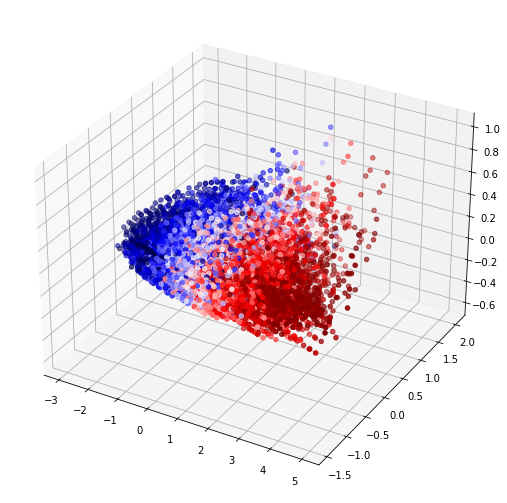

In [4]:
## set data name
dname = "nb101"
orig_data = torch.load("./dataset/{0}_unified.pt".format(dname))

## Obtain surrogates
k = mapper[dname]["k"]
stds = mapper[dname]["std"]

total_surrogate, ground_truth_perf =  obtaining_surrogate (dataset = orig_data, k = k, std = stds, is_301 = False)
    
## Visualization

pca = PCA(n_components=3)
newX = pca.fit_transform(total_surrogate.cpu().numpy())

ranks = np.array(ground_truth_perf).argsort().argsort()

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newX[:, 0], newX[:, 1], newX[:, 2], c = ranks, cmap = "seismic")
# ax.scatter(newX[:,1], newX[:, 0], newX[:, 2], c = ranks, cmap = "seismic")

### 2.3. NAS-Bench-201 datasets

100%|██████████| 15625/15625 [00:27<00:00, 569.47it/s]


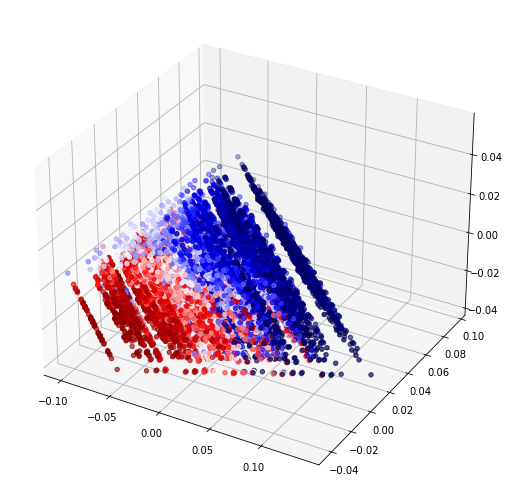

In [5]:
## set data name
dname = "nb201"
orig_data = torch.load("./dataset/{0}_unified.pt".format(dname))

## Obtain surrogates
k = mapper[dname]["k"]
stds = mapper[dname]["std"]

total_surrogate, ground_truth_perf =  obtaining_surrogate (dataset = orig_data, k = k, std = stds, is_301 = False)
    
## Visualization

pca = PCA(n_components=3)
newX = pca.fit_transform(total_surrogate.cpu().numpy())

ranks = np.array(ground_truth_perf).argsort().argsort()

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newX[:, 0], newX[:, 1], newX[:, 2], c = ranks, cmap = "seismic")

### 2.4. NAS-Bench-301 dataset

100%|██████████| 11221/11221 [01:10<00:00, 159.31it/s]


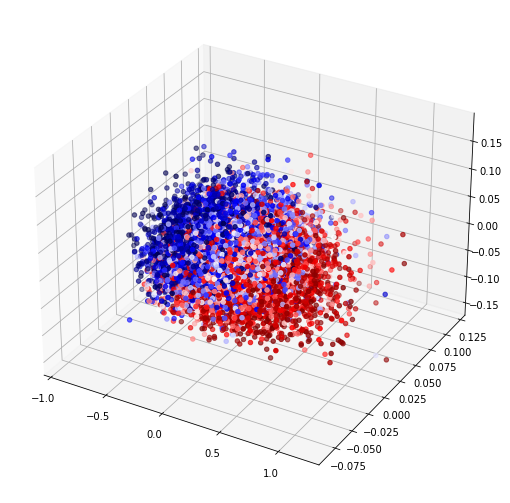

In [6]:
## set data name
dname = "nb301"
orig_data = torch.load("./dataset/{0}_unified.pt".format(dname))

## Obtain surrogates
k = mapper[dname]["k"]
stds = mapper[dname]["std"]

total_surrogate, ground_truth_perf =  obtaining_surrogate (dataset = orig_data, k = k, std = stds, is_301 = True)
    
## Visualization
pca = PCA(n_components=3)
newX = pca.fit_transform(total_surrogate.cpu().numpy())

ranks = np.array(ground_truth_perf).argsort().argsort()

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newX[:,0], newX[:, 2], newX[:, 1], c = ranks, cmap = "seismic")